This notebook shows how to create FVCOM forcing data for an unstructured grid.

We need an SMS unstructured grid (`.2dm` file) in which we have defined some nodestrings to act as open boundaries.

We'll be making the following files:

- casename_grd.dat
- casename_dep.dat
- sigma.dat
- casename_obc.dat
- casename_cor.dat
- casename_elevtide.nc


In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import PyFVCOM as pf

In [4]:
# Define a start, end and sampling interval for the tidal data
start = datetime.strptime('2018-04-01', '%Y-%m-%d')
end = datetime.strptime('2018-05-01', '%Y-%m-%d')
interval = 1 / 24  # 1 hourly in units of days
model = pf.preproc.Model(start, end, 'estuary.2dm', sampling=interval,
                         native_coordinates='spherical', zone='20N')

In [5]:
# Define everything we need for the open boundaries.

# We need the TPXO data to predict tides at the boundary. Get that from here:
#    ftp://ftp.oce.orst.edu/dist/tides/Global/tpxo9_netcdf.tar.gz
# and extract its contents in the PyFVCOM/examples directory.
tpxo_harmonics = 'h_tpxo9.v1.nc'
constituents = ['M2', 'S2']
for boundary in model.open_boundaries:
    # Create a 5km sponge layer for all open boundaries.
    boundary.add_sponge_layer(5000, 0.001)
    # Set the type of open boundary we've got.
    boundary.add_type(1)  # prescribed surface elevation
    # And add some tidal data.
    boundary.add_tpxo_tides(tpxo_harmonics, predict='zeta', constituents=constituents, interval=interval)

In [6]:
# Make a vertical grid with 21 uniform levels
model.sigma.type = 'uniform'
model.dims.levels = 21

In [7]:
# Write out the files for FVCOM.
model.write_grid('estuary_grd.dat', depth_file='estuary_dep.dat')
model.write_sponge('estuary_spg.dat')
model.write_obc('estuary_obc.dat')
model.write_coriolis('estuary_cor.dat')
model.write_sigma('sigma.dat')
model.write_tides('estuary_elevtide.nc')

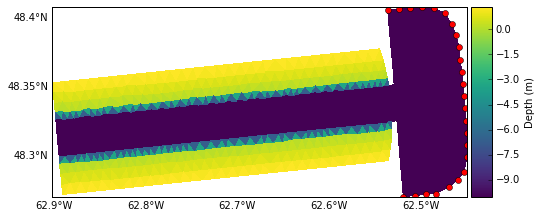

In [9]:
# Let's have a look at the grid we've just worked on.
mesh = pf.read.Domain('estuary.2dm', native_coordinates='spherical', zone='20N')
domain = pf.plot.Plotter(mesh, figsize=(20, 10), tick_inc=(0.1, 0.05), cb_label='Depth (m)')
domain.plot_field(-mesh.grid.h)
for boundary in model.open_boundaries:
    domain.axes.plot(*domain.m(boundary.grid.lon, boundary.grid.lat), 'ro')